In [1]:
import pandas as pd
import numpy as np

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from textrec.paths import paths

In [3]:
dataset = pd.read_csv(paths.data / 'num_details_training_set.csv')

# Try word frequency distribution

In [7]:
import wordfreq

In [9]:
text = dataset.text.iloc[0]
[wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')]

[4.99, 5.11, 5.73, 6.68, 7.77, 5.54, 4.72, 2.96, 6.92, 7.36, 4.01, 5.93]

In [10]:
dataset['min_freq'] = [
    np.min([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

In [11]:
dataset['mean_freq'] = [
    np.mean([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


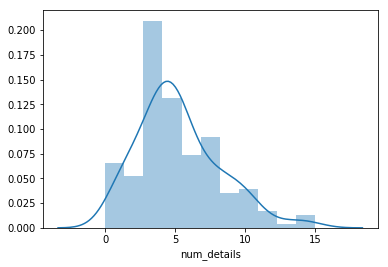

In [28]:
sns.distplot(dataset.num_details)

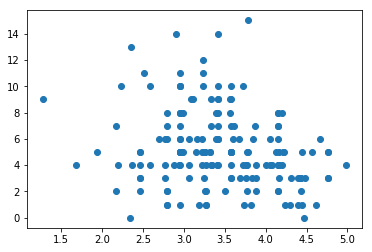

In [15]:
plt.scatter(dataset.min_freq, dataset.num_details)

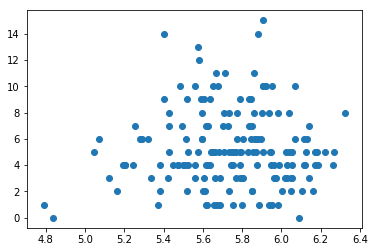

In [16]:
plt.scatter(dataset.mean_freq, dataset.num_details)

In [23]:
from sklearn.linear_model import RidgeCV, LinearRegression

In [25]:
model = (#RidgeCV(alphas=[.1, 1., 10.], store_cv_values=True)
    LinearRegression()
    .fit(dataset[['min_freq', 'mean_freq']], dataset['num_details']))

In [26]:
model.score(dataset[['min_freq', 'mean_freq']], dataset['num_details'])

0.0661016501614683

Even on the training set, that's abysmal performance.

# Perplexity

The perplexity of a language model is a rough proxy for the amout of information that a text contains. The more details included, the more uncertainty the LM has; and redundant text doesn't get counted. It's not quite right for a few reasons:

- Typos, grammar errors, etc. also increase perplexity
- Unusual wording of the same concepts increases perplexity
- Using a word that's _more_ common than expected increases perplexity.

But we'll try it anyway.

In [421]:
# dataset['image_id'] = dataset['image_id'].astype('category')#pd.Categorical(values=dataset.image_id.unique()))
# dataset['image_id'] = dataset.image_id.astype(int)

In [187]:
from textrec import automated_analyses
from textrec import onmt_model_2

In [297]:
text_old = dataset.text.copy()

Strip off punctuation; it just throws off token counts and probs. (We get a few percent boost in r^2 because of this.)

In [298]:
dataset['text'] = dataset.text.str.strip().str.rstrip('.')

In [342]:
def strip_uninformative(text):
    text = text.strip()
    for beginning in ['there is', 'there are', 'a view of', 'a photo of', 'a photo shows']:
        beginning = beginning + ' '
        if text.startswith(beginning):
            text = text[len(beginning):]
            return strip_uninformative(text)
    return text

In [345]:
strip_uninformative('there is a view of a red thing there')

'a red thing there'

In [347]:
dataset['text'] = dataset.text.apply(strip_uninformative)

In [348]:
automated_analyses.eval_logprobs_unconditional(dataset.text.iloc[0])

3.3479643

In [300]:
text

'families stand around by the water flying kites on a sunny day'

In [301]:
tokens = onmt_model_2.tokenize(text)
logprobs = onmt_model_2.models['coco_lm'].eval_logprobs('.', tokens, use_eos=True)
logprobs

array([1.0859766e+01, 4.1381788e+00, 2.3187706e+00, 7.0211720e+00,
       1.5096430e+00, 2.1149969e+00, 5.2354274e+00, 3.4142053e-01,
       5.1307883e+00, 1.5549884e+00, 1.9299134e+00, 3.4333759e-03,
       1.3650393e+00], dtype=float32)

In [349]:
dataset['num_tokens'] = dataset.text.apply(lambda text: len(onmt_model_2.tokenize(text)))

In [350]:
dataset['mean_logprob_uncond'] = dataset.text.apply(lambda text: automated_analyses.eval_logprobs_unconditional(text))

________________________________________________________________________________
[Memory] Calling textrec.automated_analyses.eval_logprobs_unconditional...
eval_logprobs_unconditional('one kite flying over four other kites on a blue sky')
______________________________________eval_logprobs_unconditional - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling textrec.automated_analyses.eval_logprobs_unconditional...
eval_logprobs_unconditional(('people walking down the street with a red double decker bus in the middle of '
 'the street'))
______________________________________eval_logprobs_unconditional - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling textrec.automated_analyses.eval_logprobs_unconditional...
eval_logprobs_unconditional('a bathroom looking toward the toilet from behind the sink')
______________________________________eval_logprobs_unconditional - 0.1s,

In [351]:
dataset['total_logprob_uncond'] = dataset.mean_logprob_uncond * (dataset.num_tokens + 1)

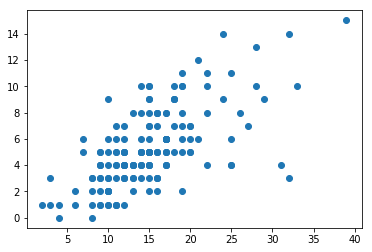

In [352]:
plt.scatter(dataset.num_tokens, dataset.num_details)

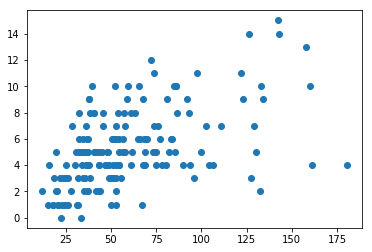

In [353]:
plt.scatter(dataset.total_logprob_uncond, dataset.num_details)

That looks more likely to be useful.

In [354]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 14 columns):
image_id                168 non-null int64
text                    168 non-null object
num_details             168 non-null int64
min_freq                168 non-null float64
mean_freq               168 non-null float64
pmi_mean                168 non-null float64
num_details_tertile     168 non-null float64
pmi_median              168 non-null float64
pmi_max                 168 non-null float64
num_tokens              168 non-null int64
mean_logprob_uncond     168 non-null float64
total_logprob_uncond    168 non-null float64
mean_rarity             168 non-null float64
max_rarity              168 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 18.5+ KB


In [355]:
cols = 'num_tokens mean_logprob_uncond total_logprob_uncond'.split()
ds = dataset[['image_id'] + cols]
ds_dummies = pd.get_dummies(ds, columns=['image_id'])
model = (
    LinearRegression()
    .fit(ds_dummies, dataset['num_details']))

In [356]:
model.score(ds_dummies, dataset['num_details'])

0.6918395430381847

*much* better.

In [357]:
model.coef_

array([ 0.3840548 ,  0.27468611, -0.01398336,  2.32427988, -1.87983399,
       -2.02801789, -1.38811832,  1.75734072,  0.32700752,  0.34043272,
        0.54690937])

In [358]:
import statsmodels.api as sm

In [359]:
X_train = sm.add_constant(ds_dummies)
smodel = sm.OLS(dataset['num_details'], X_train).fit()

In [360]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     35.25
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.11e-35
Time:                        14:03:24   Log-Likelihood:                -320.67
No. Observations:                 168   AIC:                             663.3
Df Residuals:                     157   BIC:                             697.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6086      1.075     -0.566      0.572      -2.732       1.515
num_tokens               0.3841      0.084      4.577      0.000       0.218       0.550
mean_logprob_uncond      0.2747      0.303      0.908      0.365      -0.323       0.872
total_logprob_uncond    -0.0140      0.019     -0.728      0.468      -0.052       0.024
image_id_200451          2.2482      0.371      6.065      0.000       1.516       2.980
image_id_223777         -1.9559      0.357     -5.482      0.000      -2.661      -1.251
image_id_227326         -2.1041      0.402     -5.233      0.000      -2.898      -1.310
image_id_240275         -1.4642      0.365     -4.017      0.000      -2.184      -0.744
image_id_247576          1.6813      0.386      4.354      0.000       0.919       2.444
image_id_275449          0.2509      0.361      0.695      0.488      -0.462       0.964
image_id_396295          0.2644      0.394      0.671      0.503      -0.514       1.042
image_id_431140          0.4708      0.384      1.228      0.221      -0.287       1.228
==============================================================================
Omnibus:                        4.021   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.813
Skew:                          -0.093   Prob(JB):                       0.0901
Kurtosis:                       3.808   Cond. No.                     1.05e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.37e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [424]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 14 columns):
image_id                168 non-null category
text                    168 non-null object
num_details             168 non-null int64
min_freq                168 non-null float64
mean_freq               168 non-null float64
pmi_mean                168 non-null float64
num_details_tertile     168 non-null float64
pmi_median              168 non-null float64
pmi_max                 168 non-null float64
num_tokens              168 non-null int64
mean_logprob_uncond     168 non-null float64
total_logprob_uncond    168 non-null float64
mean_rarity             168 non-null float64
max_rarity              168 non-null float64
dtypes: category(1), float64(10), int64(2), object(1)
memory usage: 17.7+ KB


In [429]:
smf.ols('num_details ~ C(image_id)', dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     9.895
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.12e-10
Time:                        15:09:23   Log-Likelihood:                -389.33
No. Observations:                 168   AIC:                             794.7
Df Residuals:                     160   BIC:                             819.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.0000      0.549     12.747      0.000       5.915       8.085
C(image_id)[T.223777]    -3.6190      0.777     -4.660      0.000      -5.153      -2.085
C(image_id)[T.227326]    -2.7143      0.777     -3.495      0.001      -4.248      -1.180
C(image_id)[T.240275]    -4.0952      0.777     -5.273      0.000      -5.629      -2.561
C(image_id)[T.247576]     0.7619      0.777      0.981      0.328      -0.772       2.296
C(image_id)[T.275449]    -1.7143      0.777     -2.207      0.029      -3.248      -0.180
C(image_id)[T.396295]    -2.0476      0.777     -2.636      0.009      -3.581      -0.514
C(image_id)[T.431140]    -0.5238      0.777     -0.674      0.501      -2.058       1.010
==============================================================================
Omnibus:                       18.380   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.014
Skew:                           0.702   Prob(JB):                     1.01e-05
Kurtosis:                       4.148   Cond. No.                         8.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [415]:
cols = 'num_tokens'.split()
ds = dataset[['image_id'] + cols].copy()
ds_dummies = pd.get_dummies(ds, columns=['image_id'])

smodel = sm.OLS(dataset['num_details'], sm.add_constant(ds_dummies)).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     44.24
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           1.10e-36
Time:                        15:01:48   Log-Likelihood:                -321.17
No. Observations:                 168   AIC:                             660.3
Df Residuals:                     159   BIC:                             688.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2932      0.331      0.885      0.377      -0.361       0.947
num_tokens          0.3279      0.023     14.105      0.000       0.282       0.374
image_id_200451     2.3662      0.344      6.883      0.000       1.687       3.045
image_id_223777    -1.8774      0.346     -5.422      0.000      -2.561      -1.194
image_id_227326    -1.9563      0.361     -5.414      0.000      -2.670      -1.243
image_id_240275    -1.3699      0.345     -3.972      0.000      -2.051      -0.689
image_id_247576     1.8010      0.356      5.063      0.000       1.098       2.503
image_id_275449     0.3240      0.344      0.941      0.348      -0.356       1.004
image_id_396295     0.4435      0.344      1.289      0.199      -0.236       1.123
image_id_431140     0.5621      0.355      1.584      0.115      -0.139       1.263
==============================================================================
Omnibus:                        3.903   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                4.337
Skew:                          -0.138   Prob(JB):                        0.114
Kurtosis:                       3.737   Cond. No.                     1.89e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So it's almost all `num_tokens`.

In [361]:
dataset.mean_freq.describe()

count    168.000000
mean       5.741087
std        0.284630
min        4.790000
25%        5.588488
50%        5.764444
75%        5.946818
max        6.323333
Name: mean_freq, dtype: float64

Let's try including the interaction of mean_freq and tokens. That's sorta like the total word frequency.. if we invert frequency to make `rarity`, then it's total rarity, or something proportional to unigram perplexity.

In [362]:
cols = 'num_tokens mean_freq min_freq'.split()
ds = dataset[['image_id'] + cols].copy()
ds['mean_freq_X_tokens'] = ds['mean_freq'] * ds['num_tokens']
ds['min_freq_X_tokens'] = ds['min_freq'] * ds['num_tokens']
ds_dummies = pd.get_dummies(ds, columns=['image_id'])

smodel = sm.OLS(dataset['num_details'], sm.add_constant(ds_dummies)).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     36.73
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.05e-39
Time:                        14:03:31   Log-Likelihood:                -306.44
No. Observations:                 168   AIC:                             638.9
Df Residuals:                     155   BIC:                             679.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3326      5.026     -0.464      0.643     -12.261       7.596
num_tokens             1.5337      0.410      3.739      0.000       0.723       2.344
mean_freq              0.3184      1.020      0.312      0.755      -1.696       2.333
min_freq               0.2189      0.497      0.441      0.660      -0.762       1.200
mean_freq_X_tokens    -0.1950      0.073     -2.674      0.008      -0.339      -0.051
min_freq_X_tokens     -0.0158      0.029     -0.543      0.588      -0.073       0.042
image_id_200451        1.9013      0.687      2.767      0.006       0.544       3.259
image_id_223777       -2.1001      0.768     -2.735      0.007      -3.617      -0.583
image_id_227326       -2.1421      0.672     -3.188      0.002      -3.469      -0.815
image_id_240275       -1.8074      0.680     -2.656      0.009      -3.152      -0.463
image_id_247576        1.4556      0.691      2.107      0.037       0.091       2.820
image_id_275449       -0.0435      0.742     -0.059      0.953      -1.509       1.422
image_id_396295       -0.1194      0.714     -0.167      0.868      -1.530       1.292
image_id_431140        0.5229      0.741      0.705      0.482      -0.941       1.987
==============================================================================
Omnibus:                        5.218   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                4.907
Skew:                          -0.331   Prob(JB):                       0.0860
Kurtosis:                       3.512   Cond. No.                     1.45e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.75e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [363]:
dataset['mean_rarity'] = (7 - dataset.mean_freq) / 7
dataset['max_rarity'] = (7 - dataset.min_freq) / 7

In [364]:
cols = 'num_tokens mean_rarity max_rarity'.split()
ds = dataset[['image_id'] + cols].copy()
ds['total_rarity'] = ds['mean_rarity'] * ds['num_tokens']
ds['max_rarity_X_tokens'] = ds['max_rarity'] * ds['num_tokens']
ds_dummies = pd.get_dummies(ds, columns=['image_id'])

smodel = sm.OLS(dataset['num_details'], sm.add_constant(ds_dummies)).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     36.73
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.05e-39
Time:                        14:03:35   Log-Likelihood:                -306.44
No. Observations:                 168   AIC:                             638.9
Df Residuals:                     155   BIC:                             679.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0108      1.735      0.583      0.561      -2.416       4.437
num_tokens              0.0584      0.122      0.479      0.633      -0.183       0.299
mean_rarity            -2.2291      7.139     -0.312      0.755     -16.331      11.873
max_rarity             -1.5322      3.477     -0.441      0.660      -8.401       5.336
total_rarity            1.3648      0.510      2.674      0.008       0.357       2.373
max_rarity_X_tokens     0.1106      0.204      0.543      0.588      -0.292       0.513
image_id_200451         2.3192      0.434      5.345      0.000       1.462       3.176
image_id_223777        -1.6822      0.368     -4.572      0.000      -2.409      -0.955
image_id_227326        -1.7241      0.408     -4.227      0.000      -2.530      -0.918
image_id_240275        -1.3894      0.466     -2.981      0.003      -2.310      -0.469
image_id_247576         1.8735      0.391      4.789      0.000       1.101       2.646
image_id_275449         0.3745      0.367      1.021      0.309      -0.350       1.099
image_id_396295         0.2986      0.374      0.799      0.425      -0.439       1.036
image_id_431140         0.9408      0.384      2.451      0.015       0.183       1.699
==============================================================================
Omnibus:                        5.218   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                4.907
Skew:                          -0.331   Prob(JB):                       0.0860
Kurtosis:                       3.512   Cond. No.                     2.22e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [430]:
dataset['total_rarity'] = dataset['mean_rarity'] * dataset['num_tokens']

In [431]:
smf.ols('num_details ~ C(image_id) + total_rarity', dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     51.19
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.48e-40
Time:                        15:10:43   Log-Likelihood:                -312.52
No. Observations:                 168   AIC:                             643.0
Df Residuals:                     159   BIC:                             671.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.2988      0.463      4.963      0.000       1.384       3.214
C(image_id)[T.223777]    -3.7573      0.493     -7.617      0.000      -4.731      -2.783
C(image_id)[T.227326]    -3.7030      0.497     -7.446      0.000      -4.685      -2.721
C(image_id)[T.240275]    -3.7526      0.494     -7.601      0.000      -4.728      -2.778
C(image_id)[T.247576]    -0.2082      0.497     -0.419      0.676      -1.190       0.774
C(image_id)[T.275449]    -1.7906      0.493     -3.631      0.000      -2.765      -0.817
C(image_id)[T.396295]    -2.0451      0.493     -4.147      0.000      -3.019      -1.071
C(image_id)[T.431140]    -0.9751      0.494     -1.974      0.050      -1.951       0.001
total_rarity              1.9053      0.124     15.420      0.000       1.661       2.149
==============================================================================
Omnibus:                        2.087   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.352   Jarque-Bera (JB):                1.737
Skew:                          -0.238   Prob(JB):                        0.420
Kurtosis:                       3.145   Cond. No.                         25.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary: num_details increases by 1.4 for each additional token of rarity.

In [436]:
smodel = smf.ols('num_details ~ C(image_id) + num_tokens + total_rarity', dataset).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     49.71
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           1.19e-41
Time:                        15:15:12   Log-Likelihood:                -306.71
No. Observations:                 168   AIC:                             633.4
Df Residuals:                     158   BIC:                             664.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0970      0.453      4.631      0.000       1.203       2.991
C(image_id)[T.223777]    -3.9719      0.482     -8.236      0.000      -4.924      -3.019
C(image_id)[T.227326]    -4.0375      0.492     -8.205      0.000      -5.009      -3.066
C(image_id)[T.240275]    -3.7199      0.479     -7.774      0.000      -4.665      -2.775
C(image_id)[T.247576]    -0.4311      0.486     -0.886      0.377      -1.392       0.529
C(image_id)[T.275449]    -1.9020      0.479     -3.970      0.000      -2.848      -0.956
C(image_id)[T.396295]    -1.9935      0.478     -4.169      0.000      -2.938      -1.049
C(image_id)[T.431140]    -1.3572      0.492     -2.758      0.006      -2.329      -0.385
num_tokens                0.1377      0.041      3.363      0.001       0.057       0.219
total_rarity              1.2483      0.229      5.448      0.000       0.796       1.701
==============================================================================
Omnibus:                        5.453   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.227
Skew:                          -0.331   Prob(JB):                       0.0733
Kurtosis:                       3.555   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [434]:
smf.ols('num_details ~ C(image_id) + num_tokens + total_rarity + total_logprob_uncond', dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     46.04
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           1.18e-41
Time:                        15:12:36   Log-Likelihood:                -304.53
No. Observations:                 168   AIC:                             631.1
Df Residuals:                     157   BIC:                             665.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.8320      0.467      3.922      0.000       0.909       2.755
C(image_id)[T.223777]    -3.8457      0.482     -7.985      0.000      -4.797      -2.894
C(image_id)[T.227326]    -4.0139      0.487     -8.234      0.000      -4.977      -3.051
C(image_id)[T.240275]    -3.7357      0.474     -7.882      0.000      -4.672      -2.800
C(image_id)[T.247576]    -0.4469      0.482     -0.928      0.355      -1.398       0.505
C(image_id)[T.275449]    -1.9371      0.475     -4.080      0.000      -2.875      -0.999
C(image_id)[T.396295]    -1.7661      0.487     -3.629      0.000      -2.727      -0.805
C(image_id)[T.431140]    -1.3928      0.488     -2.856      0.005      -2.356      -0.430
num_tokens                0.1718      0.044      3.914      0.000       0.085       0.259
total_rarity              1.4519      0.248      5.852      0.000       0.962       1.942
total_logprob_uncond     -0.0139      0.007     -2.029      0.044      -0.027      -0.000
==============================================================================
Omnibus:                        4.032   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                3.679
Skew:                          -0.270   Prob(JB):                        0.159
Kurtosis:                       3.484   Cond. No.                         593.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [365]:
cols = 'num_tokens mean_rarity max_rarity total_logprob_uncond mean_logprob_uncond'.split()
ds = dataset[['image_id'] + cols].copy()
ds['total_rarity'] = ds['mean_rarity'] * ds['num_tokens']
ds['max_rarity_X_tokens'] = ds['max_rarity'] * ds['num_tokens']
ds_dummies = pd.get_dummies(ds, columns=['image_id'])

smodel = sm.OLS(dataset['num_details'], sm.add_constant(ds_dummies)).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     32.80
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           5.66e-39
Time:                        14:03:39   Log-Likelihood:                -303.07
No. Observations:                 168   AIC:                             636.1
Df Residuals:                     153   BIC:                             683.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0557      1.767     -0.032      0.975      -3.547       3.436
num_tokens               0.1453      0.125      1.159      0.248      -0.102       0.393
mean_rarity             -6.4108      8.800     -0.728      0.467     -23.796      10.975
max_rarity              -1.5883      3.436     -0.462      0.645      -8.376       5.199
total_logprob_uncond    -0.0422      0.021     -2.047      0.042      -0.083      -0.001
mean_logprob_uncond      0.4864      0.341      1.428      0.155      -0.186       1.159
total_rarity             1.7773      0.583      3.046      0.003       0.625       2.930
max_rarity_X_tokens      0.1516      0.202      0.750      0.454      -0.248       0.551
image_id_200451          2.1233      0.435      4.880      0.000       1.264       2.983
image_id_223777         -1.6347      0.365     -4.479      0.000      -2.356      -0.914
image_id_227326         -1.9056      0.409     -4.657      0.000      -2.714      -1.097
image_id_240275         -1.5670      0.467     -3.357      0.001      -2.489      -0.645
image_id_247576          1.6916      0.393      4.307      0.000       0.916       2.468
image_id_275449          0.1932      0.369      0.524      0.601      -0.536       0.922
image_id_396295          0.3035      0.385      0.788      0.432      -0.458       1.065
image_id_431140          0.7401      0.387      1.911      0.058      -0.025       1.505
==============================================================================
Omnibus:                        3.459   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.137
Skew:                          -0.226   Prob(JB):                        0.208
Kurtosis:                       3.494   Cond. No.                     9.88e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.45e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [435]:
smf.ols('num_details ~ C(image_id) + num_tokens + mean_rarity + max_rarity + total_rarity + total_logprob_uncond + mean_logprob_uncond + max_rarity*num_tokens', dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     32.80
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           5.66e-39
Time:                        15:13:53   Log-Likelihood:                -303.07
No. Observations:                 168   AIC:                             636.1
Df Residuals:                     153   BIC:                             683.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0676      2.075      0.996      0.321      -2.033       6.168
C(image_id)[T.223777]    -3.7580      0.545     -6.890      0.000      -4.836      -2.680
C(image_id)[T.227326]    -4.0289      0.509     -7.916      0.000      -5.034      -3.023
C(image_id)[T.240275]    -3.6903      0.480     -7.690      0.000      -4.638      -2.742
C(image_id)[T.247576]    -0.4317      0.508     -0.850      0.397      -1.435       0.572
C(image_id)[T.275449]    -1.9301      0.492     -3.926      0.000      -2.901      -0.959
C(image_id)[T.396295]    -1.8198      0.517     -3.521      0.001      -2.841      -0.799
C(image_id)[T.431140]    -1.3832      0.512     -2.702      0.008      -2.395      -0.372
num_tokens                0.1453      0.125      1.159      0.248      -0.102       0.393
mean_rarity              -6.4108      8.800     -0.728      0.467     -23.796      10.975
max_rarity               -1.5883      3.436     -0.462      0.645      -8.376       5.199
total_rarity              1.7773      0.583      3.046      0.003       0.625       2.930
total_logprob_uncond     -0.0422      0.021     -2.047      0.042      -0.083      -0.001
mean_logprob_uncond       0.4864      0.341      1.428      0.155      -0.186       1.159
max_rarity:num_tokens     0.1516      0.202      0.750      0.454      -0.248       0.551
==============================================================================
Omnibus:                        3.459   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.137
Skew:                          -0.226   Prob(JB):                        0.208
Kurtosis:                       3.494   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [379]:
cols = 'num_tokens mean_rarity'.split()
ds = dataset[['image_id'] + cols].copy()
ds['total_rarity'] = ds['mean_rarity'] * ds['num_tokens']
ds_dummies = pd.get_dummies(ds, columns=['image_id'])

smodel = sm.OLS(dataset['num_details'], sm.add_constant(ds_dummies)).fit()
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     44.53
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           7.88e-41
Time:                        14:11:25   Log-Likelihood:                -306.60
No. Observations:                 168   AIC:                             635.2
Df Residuals:                     157   BIC:                             669.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4471      1.208      0.370      0.712      -1.939       2.833
num_tokens          0.1028      0.089      1.158      0.249      -0.073       0.278
mean_rarity        -3.0615      6.897     -0.444      0.658     -16.685      10.562
total_rarity        1.4366      0.482      2.978      0.003       0.484       2.390
image_id_200451     2.2405      0.359      6.243      0.000       1.532       2.949
image_id_223777    -1.7607      0.334     -5.264      0.000      -2.421      -1.100
image_id_227326    -1.7832      0.386     -4.614      0.000      -2.547      -1.020
image_id_240275    -1.4732      0.366     -4.024      0.000      -2.196      -0.750
image_id_247576     1.8136      0.371      4.884      0.000       1.080       2.547
image_id_275449     0.3117      0.334      0.932      0.353      -0.349       0.972
image_id_396295     0.2368      0.351      0.675      0.501      -0.456       0.930
image_id_431140     0.8615      0.350      2.462      0.015       0.170       1.553
==============================================================================
Omnibus:                        4.962   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.597
Skew:                          -0.327   Prob(JB):                        0.100
Kurtosis:                       3.479   Cond. No.                     3.06e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.84e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So logprobs help only a slight bit.

Let's look at resids.

In [438]:
predicted = smodel.predict(dataset)#sm.add_constant(ds_dummies))

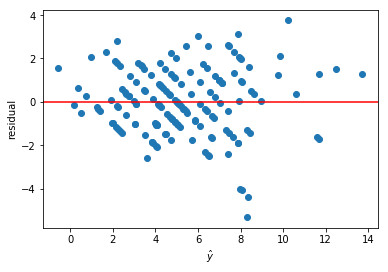

In [439]:
plt.scatter(predicted, smodel.resid)
plt.axhline(0, color='r')
plt.xlabel('$\hat{y}$')
plt.ylabel('residual');

Ok, let's have a look at captions for which length and frequency don't predict num_details well.

In [440]:
dsr = dataset.copy()

In [441]:
dsr['resid'] = smodel.resid
dsr['resid_mag'] = smodel.resid.abs()
dsr['predicted'] = predicted
dsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 18 columns):
image_id                168 non-null int64
text                    168 non-null object
num_details             168 non-null int64
min_freq                168 non-null float64
mean_freq               168 non-null float64
pmi_mean                168 non-null float64
num_details_tertile     168 non-null float64
pmi_median              168 non-null float64
pmi_max                 168 non-null float64
num_tokens              168 non-null int64
mean_logprob_uncond     168 non-null float64
total_logprob_uncond    168 non-null float64
mean_rarity             168 non-null float64
max_rarity              168 non-null float64
total_rarity            168 non-null float64
resid                   168 non-null float64
resid_mag               168 non-null float64
predicted               168 non-null float64
dtypes: float64(14), int64(3), object(1)
memory usage: 23.7+ KB


In [442]:
pd.set_option('display.max_colwidth', 150)

In [443]:
print("over-predicted:")
dsr[dsr.predicted.between(4,8)]['image_id text num_tokens resid predicted total_logprob_uncond num_details'.split()].sort_values('resid').iloc[:5]

over-predicted:


,image_id,text,num_tokens,resid,predicted,total_logprob_uncond,num_details
22,223777,"the image shows a railroad track with a train on it further out in the distance. multiple white buildings hug the side if the track, with some woo...",31,-3.999468,7.999468,180.252899,4
103,247576,a double decker bus traveling down the middle of the street in the city streets,15,-2.509847,6.509847,36.642353,4
164,431140,toilet paper roll is on top of the toilet in a mellow yellow painted bathroom,15,-2.450403,6.450403,75.009583,4
160,431140,a restroom containing a porcelain toilet and sink. a mirror sits above the sink on the wall,17,-2.405240,7.405240,85.555781,5
9,200451,one kite flying over four other kites on a blue sky,11,-2.323296,6.323296,43.533666,4


In [444]:
print("Under-predicted")
dsr[dsr.predicted.between(4,8)]['image_id text num_tokens resid predicted total_logprob_uncond num_details'.split()].sort_values('resid').iloc[-5:]

Under-predicted


,image_id,text,num_tokens,resid,predicted,total_logprob_uncond,num_details
145,396295,a tan towel is hanging from a chrome handle on a textured glass shower door,15,2.551089,6.448911,81.209793,9
120,275449,a half full glass of red wine on a table in front of a calico cat,16,2.564806,5.435194,38.410653,8
2,200451,a man and his two children are flying multicolored kites on a sandy beach,14,2.604738,7.395262,39.750552,10
7,200451,a man flies a butterfly kite with his two daughters,10,3.013312,5.986688,37.889245,9
151,431140,a bathroom with a white sink and white toilet. a roll of unwrapped toilet paper sits on the bowl,19,3.123191,7.876809,97.487974,11


I notice: 

- We can generally do surprisingly well on this task using total rarity. We can explain about 74% of the variance in details.
- Some of the over-predicts actually have more details than I gave them credit for. Some of the under-predicts are less detailed.
- Some of the over-predicted just have extra words ("there is" one kite; "a view of" a bathroom, "in the city streets"); I went back and stripped them off and the above reflects that. (we get a boost of about 0.01 R^2.)

Since this model has image only as a slope (should be random but alas I'm lazy), we can still get relative details measures.

In [380]:
ds_with_response = ds.assign(num_details=dataset.num_details)
ds_with_response.columns

Index(['image_id', 'num_tokens', 'mean_rarity', 'total_rarity', 'num_details'], dtype='object')

In [381]:
import statsmodels.formula.api as smf
md = smf.mixedlm("num_details ~ mean_rarity + num_tokens + total_rarity", ds_with_response, groups=ds_with_response["image_id"])

In [382]:
md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: num_details
No. Observations: 168     Method:             REML       
No. Groups:       8       Scale:              2.4104     
Min. group size:  21      Likelihood:         -322.9330  
Max. group size:  21      Converged:          Yes        
Mean group size:  21.0                                   
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept      0.502    1.463  0.343 0.731  -2.365  3.369
mean_rarity   -3.064    6.884 -0.445 0.656 -16.557 10.428
num_tokens     0.102    0.089  1.147 0.251  -0.072  0.275
total_rarity   1.444    0.482  2.997 0.003   0.500  2.388
groups RE      2.408    0.888                            
=========================================================

"""

In [384]:
import statsmodels.formula.api as smf
md = smf.mixedlm("num_details ~ total_rarity", ds_with_response, groups=ds_with_response["image_id"])
mdf = md.fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: num_details
No. Observations: 168     Method:             REML       
No. Groups:       8       Scale:              2.5538     
Min. group size:  21      Likelihood:         -329.0406  
Max. group size:  21      Converged:          Yes        
Mean group size:  21.0                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.262    0.644  0.407 0.684 -1.000  1.523
total_rarity    1.908    0.123 15.465 0.000  1.667  2.150
groups RE       2.359    0.848                           
=========================================================

"""

In [391]:
from sklearn.metrics import r2_score

In [393]:
r2_score(ds_with_response['num_details'], mdf.predict(sm.add_constant(ds_with_response[['image_id', 'total_rarity']])))

0.46931262224922043

I don't understand why that R^2 score is much smaller than the fixed-effects version. Probably we have different parameters.

In [413]:
smodel.params

const              0.447067
num_tokens         0.102773
mean_rarity       -3.061540
total_rarity       1.436612
image_id_200451    2.240525
image_id_223777   -1.760673
image_id_227326   -1.783225
image_id_240275   -1.473225
image_id_247576    1.813643
image_id_275449    0.311702
image_id_396295    0.236842
image_id_431140    0.861477
dtype: float64

In [414]:
mdf.params

Intercept       0.261779
total_rarity    1.908385
groups RE       0.923677
dtype: float64

In [400]:
re_params = pd.Series({k: v.iloc[0] for k, v in mdf.random_effects.items()})
re_params

200451    1.929960
223777   -1.643358
227326   -1.593033
240275   -1.638092
247576    1.730445
275449    0.227006
396295   -0.014895
431140    1.001967
dtype: float64

In [405]:
fixed_params = pd.Series({int(k[9:]): v for k, v in smodel.params.items() if k.startswith('image')})
fixed_params

200451    2.240525
223777   -1.760673
227326   -1.783225
240275   -1.473225
247576    1.813643
275449    0.311702
396295    0.236842
431140    0.861477
dtype: float64

In [412]:
d = pd.DataFrame(dict(fixed=fixed_params + smodel.params['const'], random=re_params + mdf.params['Intercept']))
d['diff'] = d['fixed'] - d['random']
d['absdiff'] = d['fixed'].abs() - d['random'].abs()
d.mean(axis=0)

fixed      0.502950
random     0.261779
diff       0.241171
absdiff    0.137865
dtype: float64

The random-effects estimates are generally smaller.

# Using Visual Genome

In [29]:
import pandas as pd
import numpy as np
import json
import ujson
import toolz
import pathlib
from IPython.display import Image, HTML

In [32]:
vg_base = pathlib.Path('/Data/VisualGenome')

In [ ]:
region_descs = ujson.load(open(vg_base / 'region_descriptions.json'))

In [36]:
regions_by_img = {r['id']: r['regions'] for r in region_descs}

In [37]:
phrases_by_img = {id: {region['phrase'].strip() for region in regions} for id, regions in regions_by_img.items()}

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [63]:
imgids = list(phrases_by_img.keys())

In [38]:
joined_captions = ['\n'.join(phrases) for phrases in phrases_by_img.values()]

In [40]:
vectorizer = CountVectorizer()

In [41]:
caption_vecs = vectorizer.fit_transform(joined_captions)

In [42]:
text = dataset.text.iloc[0]
text

'families stand around by the water flying kites on a sunny day'

In [45]:
vectorizer.vocabulary_['families']

20785

(Notice: lemmatization might matter. Ignoring for now.)

In [74]:
concept_vecs = [caption_vecs[:,vectorizer.vocabulary_[tok]].A.flatten() for tok in 'family water kites'.split()]

In [80]:
np.flatnonzero(np.product(np.array(concept_vecs), axis=0))

array([ 11352,  26031,  35352, 105935])

In [81]:
for idx in np.flatnonzero(np.product(np.array(concept_vecs), axis=0)):
    print(joined_captions[idx].replace('\n', ' // '))
    print()

blue kite shaped like a whale // part of the sky // kite seems to be a person of some sort, wearing boots, difficult to discern // people sitting and laying on the sandy beach // part of a sandy beach // long kite tail // a whale kite // a person crouched in the sand // cow spotted kite, perhaps with wings // part of a trouser // kites flying above a beach // a flying witch kite // part of some buildings // many lively & idiosyncratically shaped kites over the beachfront // a child sitting at a person's feet // several people enjoying the beach // a flying super hero kite // part of some people // buildings on the beach skyline // witch-shaped kite, in black // tail of a kite // a sandy beach // fin of a kite // people & all kinds of stuff sitting on the sand at right // kites flying in the sky on a beach // family having fun on the beach // part of a string // a flying pony kite // young child playing on beach // end of a balloon // a person stands watching the kites // edge of a buil

In [51]:
caption_vecs[:,vectorizer.vocabulary_['families']].nnz

16

In [52]:
x=caption_vecs[:,vectorizer.vocabulary_['families']]

In [62]:
x.tocsc().indices

array([ 11091,  11391,  13740,  18704,  25414,  25631,  32425,  52610,
        57154,  62114,  64161,  66207,  79459,  81329,  98800, 100670],
      dtype=int32)

In [82]:
for idx in x.tocsc().indices:
    print(joined_captions[idx].replace('\n', ' // '))
    print()

parents and families hanging out in the distance // boys on a soccer field // Soccer ball laying on grass // Soccer ball laying against net // a water bottle laying next to the goal // Boy wearing bright green shirt // the woods in the distance // Boy wearing black soccer shoe // A young boy is ready to react // The person in all black on the left // The boy in blue nearest the camera // boy playing soccer game // A soccer ball sits in the grass // a soccer goal net // The grass field the kids are playing on // The man in black behind the net // The goal at the far end of the field // a boy in a blue and white Adidas outfit // A soccer tournament at practice time // children playing soccer // A young boy // The goal set up to go // The soccer ball in the net // Boy has dark brown hair // a soccer ball sitting in the grass // The net behind the boy in blue // Boys hair is thick // A young soccer player with black socks // a goal was made at some point // Wearing a blue soccer jersey // 

## Pairwise specificity

Idea: compute how often each pair of words co-occurs in VG. Take mean of that. Why? If most concepts co-occur, low specificity. We could also use pmi.

In [84]:
text

'families stand around by the water flying kites on a sunny day'

$pmi = \frac{p(x,y)} {p(x) p(y)}$

We'll estimate $p(x,y)$ as the fraction of images containing both words, and $p(x)$ as the fraction of images containing x.

In [113]:
caption_vecs.data.fill(1)

In [123]:
words = vectorizer.transform([text])[0].indices

In [124]:
voc = vectorizer.get_feature_names()

In [125]:
', '.join([voc[w] for w in words])

'around, by, day, families, flying, kites, on, stand, sunny, the, water'

In [126]:
vecs = [caption_vecs[:,i] for i in words]

In [129]:
import itertools

In [ ]:
def pmi_indices(w1, w2):
    v1 = caption_vecs[:,w1]
    v2 = caption_vecs[:,w2]
    p_xy = v1.multiply(v2).sum() / v1.shape[0]
    p_x = v1.sum() / v1.shape[0]
    p_y = v2.sum() / v1.shape[0]
    return p_xy / (p_x * p_y)

def pmi_words(w1, w2):
    return pmi_indices(
        vectorizer.vocabulary_[w1],
        vectorizer.vocabulary_[w2])

In [177]:
def vis_pmi_stats(text):
    words = vectorizer.transform([text])[0].indices
    for idx1, idx2 in itertools.combinations(words, 2):
        w1 = voc[idx1]
        w2 = voc[idx2]
        print("{} x {} = {:.2f}".format(
            w1,
            w2,
            pmi_words(w1, w2)
        ))
vis_pmi_stats(text)

around x by = 1.13
around x day = 1.02
around x families = 2.15
around x flying = 0.78
around x kites = 0.75
around x on = 1.00
around x stand = 0.86
around x sunny = 1.04
around x the = 1.00
around x water = 0.93
by x day = 1.14
by x families = 1.54
by x flying = 1.03
by x kites = 1.02
by x on = 1.00
by x stand = 1.06
by x sunny = 1.29
by x the = 1.00
by x water = 1.23
day x families = 4.75
day x flying = 2.01
day x kites = 2.57
day x on = 1.00
day x stand = 0.73
day x sunny = 9.79
day x the = 1.01
day x water = 1.36
families x flying = 3.89
families x kites = 16.48
families x on = 1.01
families x stand = 1.05
families x sunny = 3.54
families x the = 1.01
families x water = 1.08
flying x kites = 16.96
flying x on = 0.98
flying x stand = 0.40
flying x sunny = 2.19
flying x the = 1.01
flying x water = 1.51
kites x on = 0.97
kites x stand = 0.74
kites x sunny = 2.97
kites x the = 1.01
kites x water = 2.05
on x stand = 1.01
on x sunny = 1.00
on x the = 1.00
on x water = 1.00
stand x sunny

In [131]:
def pmi_stats(text):
    words = vectorizer.transform([text])[0].indices
    pmis = []
    for idx1, idx2 in itertools.combinations(words, 2):
        pmis.append(pmi_indices(idx1, idx2))
    return pmis
pmi_stats(dataset.text.iloc[0])

[1.1301771004157908,
 1.0242295114248008,
 2.1491608335984727,
 0.7805541187057029,
 0.7548272196053173,
 1.0028735923464738,
 0.8629979162431716,
 1.0411440224787154,
 1.0014342145602793,
 0.9255657962597963,
 1.1448862580591157,
 1.541373507264015,
 1.0330985010343166,
 1.0225697414044195,
 1.0022024829381304,
 1.0615322432530208,
 1.2940324468177724,
 1.0021630750534556,
 1.2304583372762838,
 4.745214260625219,
 2.008710331184909,
 2.5693599167287773,
 0.9997189955813587,
 0.7272020613460086,
 9.79368474953555,
 1.0073975502931682,
 1.360565716269201,
 3.885053201687117,
 16.47515243902439,
 1.0076827687803604,
 1.0477450752287887,
 3.5384036144578315,
 1.008105738377733,
 1.084819994646681,
 16.95525657451743,
 0.9835339294211685,
 0.40495668551787534,
 2.1925077611057726,
 1.0059797485153565,
 1.5107615876367888,
 0.9732740888707871,
 0.735977028453393,
 2.9688069350573025,
 1.0068763411358088,
 2.0532202825507913,
 1.005181927412207,
 1.0018763201388812,
 1.0002479031909894,
 0.9

In [132]:
import tqdm

In [133]:
pmis_by_text = {text: pmi_stats(text) for text in tqdm.tqdm_notebook(dataset.text)}

In [167]:
dataset['pmi_mean'] = dataset.text.apply(lambda text: np.mean(pmis_by_text[text]))
dataset['pmi_median'] = dataset.text.apply(lambda text: np.median(pmis_by_text[text]))
dataset['pmi_max'] = dataset.text.apply(lambda text: np.max(pmis_by_text[text]))
dataset['num_details_tertile'] = np.floor(3 * dataset.num_details.rank() / (len(dataset.num_details) + 1))

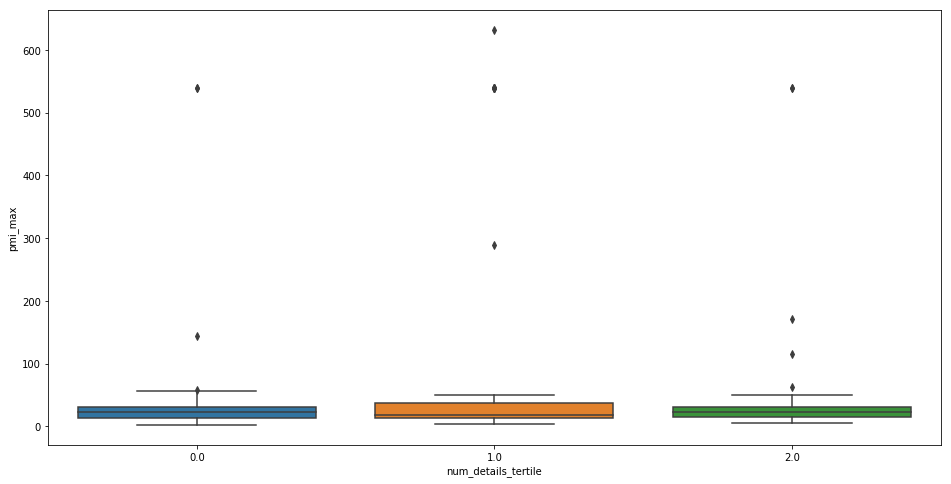

In [178]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='num_details_tertile', y='pmi_max', data=dataset)

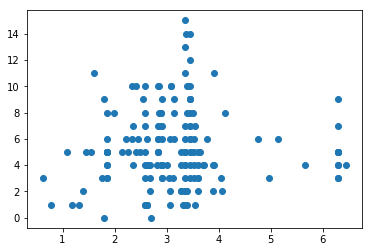

In [170]:
plt.scatter(np.log(dataset.pmi_max), dataset.num_details)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


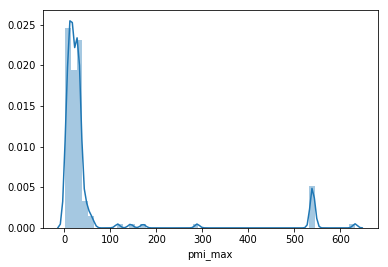

In [171]:
sns.distplot(dataset.pmi_max)

In [153]:
dataset[dataset.pmi_median > 3]

,image_id,text,num_details,min_freq,mean_freq,pmi_mean,num_details_tertile,pmi_median
58,227326,a bride and groom cut a wedding cake together,4,3.58,5.506667,43.991618,1.0,3.508740
86,247576,a double-decker bus drives through a busy city...,6,3.42,5.512500,5.197876,2.0,3.135472
87,247576,old european architecture,3,4.42,5.120000,9.070776,0.0,3.962960
146,396295,a shower door,1,4.44,5.620000,3.744778,0.0,3.744778


In [175]:
print('\n'.join(dataset[dataset.pmi_max > 300].text))

an old train is stopped on the train tracks in front of a lovely cape cod cottage with bright blue trim and adjacent matching cottages
a bride and groom are both holding onto the same knife to cut their wedding cake.
a black and white picture of a bride and groom cutting their wedding cake with a photographer helping them pose
a bride and a groom are seen cutting a cake with a photographer in black and white
a bride and a groom are cutting a cake with the help of a woman
a bride and groom cutting a cake with the photographer showing them how to cut the four tier cake
a groom and bride slicing a white wedding cake on the banquet food table
wedding photographer is guiding a bride and groom as to how they should cut their cake
a woman in black helps a bride and groom cut into their wedding cake
a bride and groom cut a wedding cake together
a black and white photo of a wedding. the groom and a camerawoman are helping the bride cut the wedding cake on the table filled with glasses and choco

In [179]:
vis_pmi_stats('a bride and groom cut a wedding cake together')

and x bride = 1.12
and x cake = 1.00
and x cut = 1.01
and x groom = 1.15
and x together = 1.04
and x wedding = 1.03
bride x cake = 32.40
bride x cut = 5.78
bride x groom = 539.65
bride x together = 3.11
bride x wedding = 129.53
cake x cut = 4.42
cake x groom = 34.51
cake x together = 1.04
cake x wedding = 14.53
cut x groom = 6.02
cut x together = 1.18
cut x wedding = 3.57
groom x together = 3.51
groom x wedding = 136.68
together x wedding = 1.53


In [154]:
pmis_by_text['a shower door']

[3.744777716297541]

Getting some intuition for this quantity...

In [157]:
pmi_words('shower', 'door')

3.744777716297541

In [158]:
pmi_words('toilet', 'sink')

17.295256503294784

In [160]:
pmi_words('ski', 'slope')

20.29426663596592

In [161]:
pmi_words('ski', 'hot')

0.31500862741875846

In [163]:
pmi_words('ski', 'cold')

6.28228002748861

In [164]:
pmi_words('ski', 'snow')

16.236652436884246

In [165]:
pmi_words('cat', 'glass')

0.9902118841808273

In [166]:
pmi_words('glass', 'vase')

3.989688326300417

In [180]:
pmi_words('bride', 'groom')

539.6538560659751

In [181]:
pmi_words('cake', 'together')

1.0445281709771077

In [182]:
pmi_words('cut', 'cake')

4.421686079012107

Summary: pmi is extremely high for word pairs like "bride" and "groom" (no surprise that it's used for finding collocations). If we know "bride" is in the image, that makes it extremely likely that "groom" is too. On the other hand, it's close to 1 for words that aren't clearly associated (like "cake" and "together"), and spans a range in between.

A highly specific caption is one that includes many words that aren't redundant with each other. e.g., once we have "bride", "groom" doesn't really "count" as a new word. But "together" doesn't really add much either, because it's common overall. So what measure do we put on the value of a new word?

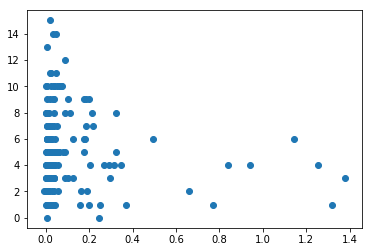

In [151]:
plt.scatter(np.log(dataset.pmi_median), dataset.num_details)